In [2]:
import numpy as np
import pytesseract
import cv2
from PIL import Image
import matplotlib.pyplot as plt

In [4]:
pytesseract.pytesseract.tesseract_cmd = r'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

In [157]:
print(pytesseract.image_to_string(Image.open('./test_imgs/photo_2023-01-14_16-32-26.jpg')))


MSs ULOE 2529

lable No: 254
DINE IN
Receipt No .69980 GARDENS_GARDENS_01
Shift No.4 09-Jan-2023
PAX :
Cashier :CASHIER 09-01-23 22:22:52
QTY ITEM NAME AMOUNT
1 N35 Mee Goreng 5.50
2 N33 Maggi Goreng Ayam (Chi.. 17.00
1 N36 Mee Goreng Ayam (Chick... 8.50
2 N32 Maggi Goreng 11.00
] P31 Banana Prata 3,80
5 032 Iced Milo 12.50
1. D40 Iced Teh 0 1.90
1 D65 Blueberry/Syrup/Lime J.. 2.00
Sub Total 62.20
GST 4.97

Grand Tota]
Master Card




In [158]:
import cv2
import pytesseract
from pytesseract import Output

img = cv2.imread('./test_imgs/photo_2023-01-14_16-32-26.jpg')

d = pytesseract.image_to_data(img, output_type=Output.DICT)
print(d.keys())

KeyboardInterrupt: 

In [ ]:
n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 60:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

cv2.imshow('img', img)
cv2.waitKey(0)

-1

In [ ]:
img = cv2.imread('./test_imgs/photo_2023-01-14_16-32-26.jpg')



In [ ]:

denoised = cv2.fastNlMeansDenoisingColored(img,None,7,20,7,21)
# cv2.imshow('denoised', denoised)
# cv2.waitKey(0) 


In [ ]:
bw_image = cv2.cvtColor(denoised, cv2.COLOR_BGR2GRAY)
th3 = cv2.adaptiveThreshold(bw_image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)
cv2.imshow('img', th3)
cv2.waitKey(0) 


-1

In [ ]:
def order_points(pts):
    '''Rearrange coordinates to order:
      top-left, top-right, bottom-right, bottom-left'''
    rect = np.zeros((4, 2), dtype='float32')
    pts = np.array(pts)
    s = pts.sum(axis=1)
    # Top-left point will have the smallest sum.
    rect[0] = pts[np.argmin(s)]
    # Bottom-right point will have the largest sum.
    rect[2] = pts[np.argmax(s)]
 
    diff = np.diff(pts, axis=1)
    # Top-right point will have the smallest difference.
    rect[1] = pts[np.argmin(diff)]
    # Bottom-left will have the largest difference.
    rect[3] = pts[np.argmax(diff)]
    # Return the ordered coordinates.
    return rect.astype('int').tolist()

def find_dest(pts):
    (tl, tr, br, bl) = pts
    # Finding the maximum width.
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
 
    # Finding the maximum height.
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # Final destination co-ordinates.
    destination_corners = [[0, 0], [maxWidth, 0], [maxWidth, maxHeight], [0, maxHeight]]
 
    return order_points(destination_corners)


def scan(img):
    # Resize image to workable size
    dim_limit = 1080
    max_dim = max(img.shape)
    if max_dim > dim_limit:
        resize_scale = dim_limit / max_dim
        img = cv2.resize(img, None, fx=resize_scale, fy=resize_scale)
    # Create a copy of resized original image for later use
    orig_img = img.copy()
    # Repeated Closing operation to remove text from the document.
    kernel = np.ones((5, 5), np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=3)
    print('MorphologyEx done.')
    # GrabCut
    mask = np.zeros(img.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    rect = (20, 20, img.shape[1] - 20, img.shape[0] - 20)
    cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 4, cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    img = img * mask2[:, :, np.newaxis]

    plt.imshow(mask2)
 
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (11, 11), 0)
    print('GaussianBlur done.')
    # Edge Detection.
    canny = cv2.Canny(gray, 0, 200)
    canny = cv2.dilate(canny, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))
 
    # Finding contours for the detected edges.
    contours, hierarchy = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # Keeping only the largest detected contour.
    page = sorted(contours, key=cv2.contourArea, reverse=True)[:5]
 
    # Detecting Edges through Contour approximation.
    # Loop over the contours.
    if len(page) == 0:
        return orig_img
    for c in page:
        # Approximate the contour.
        epsilon = 0.02 * cv2.arcLength(c, True)
        corners = cv2.approxPolyDP(c, epsilon, True)
        # If our approximated contour has four points.
        if len(corners) == 4:
            break
    print('Contour Approximation done.')
    # Sorting the corners and converting them to desired shape.
    corners = sorted(np.concatenate(corners).tolist())
    # For 4 corner points being detected.
    corners = order_points(corners)
 
    destination_corners = find_dest(corners)

    print('Destination corners found.')
 
    h, w = orig_img.shape[:2]
    # Getting the homography.
    M = cv2.getPerspectiveTransform(np.float32(corners), np.float32(destination_corners))
    # Perspective transform using homography.
    final = cv2.warpPerspective(orig_img, M, (destination_corners[2][0], destination_corners[2][1]),
                                flags=cv2.INTER_LINEAR)
    return final


In [ ]:
img = cv2.imread('./test_imgs/photo_2023-01-14_16-32-26.jpg')


MorphologyEx done.
GaussianBlur done.
Contour Approximation done.
Destination corners found.


-1

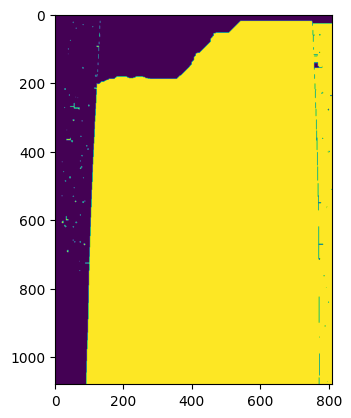

In [ ]:
scanned = scan(img)
cv2.imshow('scanned', scanned)
cv2.waitKey(0)

### chatgpt implementation??

In [ ]:
import numpy as np

def order_points(pts):
    # Initialize a list of coordinates that will be ordered such that the first entry in the list is the top-left, the second entry is the top-right, the third is the bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype="float32")

    # The top-left point will have the smallest sum, whereas the bottom-right point will have the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # Now, compute the difference between the points, the top-right point will have the smallest difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    print(rect)
    # Return the ordered coordinates
    return rect

def four_point_transform(image, pts):
    # Obtain a consistent order of the points and unpack them individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # Compute the width of the new image, which will be the maximum distance between bottom-right and bottom-left x-coordinates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # Compute the height of the new image, which will be the maximum distance between the top-right and bottom-right y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # Now that we have the dimensions of the new image, construct the set of destination points to obtain a "birds eye view", (i.e. top-down view) of the image, again specifying points in the top-left, top-right, bottom-right,
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    # Compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    # plt.imshow(warped)
    # Return the warped image
    return warped

In [14]:
import cv2
import numpy as np

def remove_shadow(img):
    rgb_planes = cv2.split(img)

    result_planes = []
    result_norm_planes = []
        
    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 21)
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        # result_planes.append(diff_img)
        result_norm_planes.append(norm_img)
        
    # result = cv2.merge(result_planes)
    result_norm = cv2.merge(result_norm_planes)
    cv2.imwrite('shadows_out_norm.png', result_norm)
    return result_norm
    # cv2.imwrite('shadows_out.png', result)


True

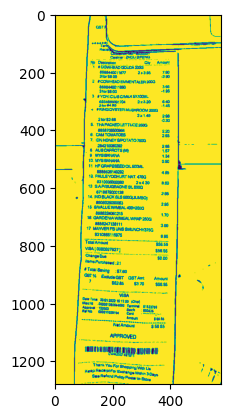

In [36]:
import cv2

# Load the image
image = cv2.imread('./test_imgs/photo_2023-01-15_02-27-37.jpg')
denoised = cv2.fastNlMeansDenoisingColored(image,None,7,20,7,21)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = remove_shadow(gray)
# denoised = cv2.fastNlMeansDenoisingColored(img,None,7,20,7,21)


# # Apply adaptive thresholding
# thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

# cv2.imwrite('thresh.png', thresh)
# kernel = np.ones((5,5),np.uint8)
# thresh = cv2.dilate(thresh,kernel,iterations = 1)
# thresh = cv2.erode(thresh,kernel,iterations = 1)

# cv2.imwrite('thresh2.png', thresh)
# Find contours
# contours, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

# # Sort contours by area and keep only the largest ones
# contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]


# # Iterate over the contours
# for cnt in contours:
#     # Approximate the contour
#     approx = cv2.approxPolyDP(cnt, 0.02*cv2.arcLength(cnt, True), True)

#     # If the contour has 4 vertices, then assume it is a document
#     if len(approx) == 4:
#         docCnt = approx
#         break
# print(docCnt)
# # Extract the document from the image
# perspective = four_point_transform(image, docCnt.reshape(4, 2))

# Apply Otsu threshold
# gray = cv2.cvtColor(perspective, cv2.COLOR_BGR2GRAY)
# gray = cv2.GaussianBlur(gray, (5, 5), 0)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
# thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            # cv2.THRESH_BINARY,11,2)

# Save the scanned image
plt.imshow(thresh)
cv2.imwrite('scanned.png', thresh)


In [37]:
# options = "--psm 4"
# text = pytesseract.image_to_string(
# 	cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB),
# 	config=options)
# print(text)
text_ocr = pytesseract.image_to_string(Image.open('./scanned.png'))
print(text_ocr)


Saaabier: ZHOU BFENG
No Desenption Qty, | Amaun!

1 #COWHEAD Gouna todd
sagaeaqotu77 = 2x395 7.90
tor $8.00 “320
2 COWHEAD EMMENTALER 2008,
888844001 1860 395
3tor $6.00 “1.95
3. #YOYIC U8 C/MIK BXT00ML
6934605001704 «23.20 840
Por 64.65 AMS
+ # KING OYSTER MUSHROOM 2006
2x149 298
2fors2.68 0.30
§. THAPACKED LETTUCE 2506
8888708500064 2.20
8. CAM TOMATOES 293
7. IDN HONEY S/POTATO 7503
‘2aa2to0802e2 2.88
& AUSGARROTS (M) 187
9 MYSBANANA 1.4
10. MYS BANANA 0.90
11 HF GRAPESEED O1L 600M.
8886626140282 4.95

12. PAULS YOGHURT NAT. 470G.

9310036002003 2x4 30 aso
13 S.AP/SUGRAQNE SL 500

8718879000138 295
14. IND BLACK SL8 S00G)JUMBO}
8908025050063 2.95
15 SNALUEWMEAL 400+200G
8886324061215 1.70
18. GARDENIA W/MEAL WRAP 2503,
8888247138111 3.00
17 MAYVER PB UNS SMUNCHY375G
9310885115975 695

“Fetal Amount
ViBA [0000027827 ] $58.55
ChangeDue 7" $0.00
toms Purchased :21

Total Saving - $7.60

GST% ErcudeGST GSTAm — Amounl
? S625 $3.70 $56.55

VISA

Cate Tena 3001-2022
Marc id. 29009 Mate Ten

In [16]:
'''import cv2

# Load the image
image = cv2.imread('./test_imgs/photo_2023-01-14_16-32-12.jpg')
denoised = cv2.fastNlMeansDenoisingColored(image,None,7,20,7,21)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = remove_shadow(gray)
# denoised = cv2.fastNlMeansDenoisingColored(img,None,7,20,7,21)


# Apply adaptive thresholding
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

cv2.imwrite('thresh.png', thresh)
kernel = np.ones((5,5),np.uint8)
thresh = cv2.dilate(thresh,kernel,iterations = 1)
thresh = cv2.erode(thresh,kernel,iterations = 1)

cv2.imwrite('thresh2.png', thresh)
# Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

# Sort contours by area and keep only the largest ones
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]


# Iterate over the contours
for cnt in contours:
    # Approximate the contour
    approx = cv2.approxPolyDP(cnt, 0.02*cv2.arcLength(cnt, True), True)
    print('approx', approx)
    # If the contour has 4 vertices, then assume it is a document
    if len(approx) == 4:
        docCnt = approx
        break
print(docCnt)
# Extract the document from the image
perspective = four_point_transform(image, docCnt.reshape(4, 2))

# Apply Otsu threshold
gray = cv2.cvtColor(perspective, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
# thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            # cv2.THRESH_BINARY,11,2)

# Save the scanned image
plt.imshow(thresh)
cv2.imwrite('scanned.png', thresh)
'''

approx [[[   0    0]]

 [[   0 1279]]

 [[ 959 1279]]

 [[ 959    0]]]
[[[   0    0]]

 [[   0 1279]]

 [[ 959 1279]]

 [[ 959    0]]]


NameError: name 'four_point_transform' is not defined

{'page_num': 0, 'orientation': 0, 'rotate': 0, 'orientation_conf': 0.72, 'script': 'Cyrillic', 'script_conf': 0.74}


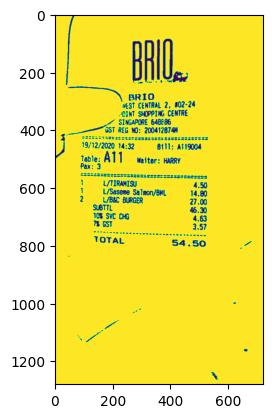

In [32]:
# image = cv2.imread(args["image"])
# import os
# for img in os.listdir('./test_imgs/receipts'):
#     print(img)
import imutils
# from pyte
img = cv2.imread('./scanned.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(img)
# rgb = cv2.cvtColor(img,  cv2.COLOR_BGR2RGB)
results = pytesseract.image_to_osd(thresh, output_type=pytesseract.Output.DICT)
print( results)
# rotated = imutils.rotate_bound(thresh, angle=-results["rotate"])
# plt.imshow(rotated)
# results2 = pytesseract.image_to_osd(rotated, output_type=pytesseract.Output.DICT)
# print(results2)

In [ ]:
print(pytesseract.image_to_string(rotated))


Metuvahee Dat cvebbnacy
(O Battato Road
“tngapate ¢ Wel?

Recedpt Nomber’ 153 2 ff 2020
PLOf
MAQVO TYPOS dea SAREE
A000 x $ 110 A. A0
VBA Cault Hrower Ciidiad
O54 ss $ 700 3.89)
VIG2 Caps feu (Gi eon)
O86? ox § Hol | 8!
KOT MURUNGA KEL RAL |
Cee LD 100
VO Potato Gmall
Q oBAKY en eee A oN
WOOF Undone Comal)
O.b68 os bb ay 3.0/
KOO? Lomato Keer ad
QO 1P8 ox fh 200 () 6A
VO Gist EN ANANE,
Ga on BCU 494
V0d  Sanbe Gaur dty’ stad
OA ox § 7 10 1.4]
VOUd Ginger
Oo 32ka ox baby | 8/
VOIO Yam (inal)
ORB xb 2a ue
vood — Yam(bia)
ee ee oe (608
VIPH Radish (lndtad
Oye oo he 6. 5 dob
10. 008
Stblatab SH
Ravina a0)
loral $ 3H. bu
CAGE Pala HO, OU
Chatiae 1 hu

Hank Yout Have A Ntee Dayt



In [ ]:
import cv2
import pytesseract

# Load the image
image = cv2.imread("example.jpg")

# Define the EAST detector
east = cv2.dnn.readNet("frozen_east_text_detection.pb")

# Create a blob from the image
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False)

# Pass the blob through the EAST detector
east.setInput(blob)
scores, geometry = east.forward(["feature_fusion/Conv_7/Sigmoid", "feature_fusion/concat_3"])

# Decode the predictions
(rects, confidences) = decode_predictions(scores, geometry)

# Loop over the bounding boxes and extract the text
for (startX, startY, endX, endY) in rects:
    # Extract the region of interest
    roi = image[startY:endY, startX:endX]

    # Pass the ROI through the OCR engine
    text = pytesseract.image_to_string(roi)

    # Draw the bounding box and text on the image
    cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
    cv2.putText(image, text, (startX, startY - 20), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 3)

# Show the output image
cv2.imshow("Text Detection", image)
cv2.waitKey(0)


In [30]:
import re
pricePattern = r'([0-9]+\.[0-9]+)'
taxPattern = r'GST\s* ([0-9]+\.[0-9]+)'
serviceTaxPattern = r'Service\s*([0-9]+\.[0-9]+)'


print(text_ocr)
print("[INFO] price line items:")
print("========================")
# loop over each of the line items in the OCR'd receipt
for row in text_ocr.split("\n"):
	# check to see if the price regular expression matches the current
	if "Total" in row:
		break
	if re.search(pricePattern, row) is not None :
		print(row)

print('_________________________')
for row in text_ocr.split("\n"):
	if re.search(taxPattern, row) is not None :
		print(row)
	if re.search(serviceTaxPattern, row) is not None :
		print(row)



hh. UZ0Z £3529

Table No: 254

DINE IN
Receipt No.69980 _GARDENS_GARDENS_01
Shift No.4 09-Jan-20
PAX + 09-Jan-2023
Cashier :CASHIER 09-01-23 22:22:52
QTY ITEM NAME AMOUNT
1 N35 Mee Goreng 5.50
2 N33 Maggi Goreng Ayam (Chi.. 17.00
1 N36 Mee Goreng Ayam (Chick.. 8.50
2 N32 Maggi Goreng 11.00
1 = P31 Banana Prata 3.80
5 032 Iced Milo 12.50
1 040 Iced Teh 0 1.90
1 D65 Biueberry/Syrup/Lime J.. 2.00
/ Sub Total 62.20
GST 4,97
Grand Total 67.17
Master Card 67.17

Thank You Fer Patronizing!
Please Come Again!

[INFO] price line items:
1 N35 Mee Goreng 5.50
2 N33 Maggi Goreng Ayam (Chi.. 17.00
1 N36 Mee Goreng Ayam (Chick.. 8.50
2 N32 Maggi Goreng 11.00
1 = P31 Banana Prata 3.80
5 032 Iced Milo 12.50
1 040 Iced Teh 0 1.90
1 D65 Biueberry/Syrup/Lime J.. 2.00
_________________________


In [ ]:
from textblob import TextBlob

# List of food items and prices
items = ["N32 Maggi Goreng 16.50", 
         "1 P13 Plain Prata 1.40", 
         "1 PIS Egg Prata 2.50", 
         "3 092 Ived Hilo 7.50", 
         "4 951 Iced Limau 2.00", 
         "4 05) Iced Linau 2.00"]

# Corrected list
corrected_items = []

# Iterate through each item in the list
for item in items:
    blob = TextBlob(item)
    corrected_item = [w.correct() if w.spellcheck()[0][1] < 0.8 else w for w in blob.words]
    corrected_items.append(" ".join(corrected_item))

print(corrected_items)


**********************************************************************
  Resource punkt not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('punkt')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load tokenizers/punkt/english.pickle

  Searched in:
    - 'C:\\Users\\arite/nltk_data'
    - 'c:\\Users\\arite\\miniconda3\\envs\\pay-split-bot\\nltk_data'
    - 'c:\\Users\\arite\\miniconda3\\envs\\pay-split-bot\\share\\nltk_data'
    - 'c:\\Users\\arite\\miniconda3\\envs\\pay-split-bot\\lib\\nltk_data'
    - 'C:\\Users\\arite\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
    - ''
**********************************************************************



MissingCorpusError: 
Looks like you are missing some required data for this feature.

To download the necessary data, simply run

    python -m textblob.download_corpora

or use the NLTK downloader to download the missing data: http://nltk.org/data.html
If this doesn't fix the problem, file an issue at https://github.com/sloria/TextBlob/issues.


In [6]:
import nltk
nltk.download('punkt')

[nltk_data] Error loading punkt: <urlopen error [WinError 10061] No
[nltk_data]     connection could be made because the target machine
[nltk_data]     actively refused it>


False

In [10]:

import cv2
import pytesseract


def decode_predictions(scores, geometry):
    # Grab the number of rows and columns from the scores volume, then
    # initialize our set of bounding box rectangles and corresponding
    # confidence scores
    (numRows, numCols) = scores.shape[2:4]
    rects = []
    confidences = []

    # Loop over the number of rows
    for y in range(0, numRows):
        # Extract the scores (probabilities), followed by the
        # geometrical data used to derive potential bounding box
        # coordinates that surround text
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        # Loop over the number of columns
        for x in range(0, numCols):
            # If our score does not have sufficient probability,
            # ignore it
            if scoresData[x] < 0.5:
                continue

            # Compute the offset factor as our resulting feature
            # maps will be 4x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)

            # Extract the rotation angle for the prediction and
            # then compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            # Use the geometry volume to derive the width and height
            # of the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            # Compute both the starting and ending (x, y)-coordinates
            # for the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            # Add the bounding box coordinates and probability score
            # to our respective lists
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    # Return a tuple of the bounding boxes and associated confidences
    return (rects, confidences)


# Load the image
image = cv2.imread("./scanned.png")

# Define the EAST detector
east = cv2.dnn.readNet("frozen_east_text_detection.pb")
(H, W) = image.shape[:2]

# Create a blob from the image
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H), (123.68, 116.78, 103.94), swapRB=True, crop=False)

# Pass the blob through the EAST detector
east.setInput(blob)
scores, geometry = east.forward(["feature_fusion/Conv_7/Sigmoid", "feature_fusion/concat_3"])

# Decode the predictions
(rects, confidences) = decode_predictions(scores, geometry)

# Loop over the bounding boxes and extract the text
for (startX, startY, endX, endY) in rects:
    # Extract the region of interest
    roi = image[startY:endY, startX:endX]

    # Pass the ROI through the OCR engine
    text = pytesseract.image_to_string(roi)
    print(text)
    # Draw the bounding box and text on the image
    cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
    cv2.putText(image, text, (startX, startY - 20), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 3)

# Show the output image
cv2.imshow("Text Detection", image)
cv2.waitKey(0)







ADe yy]






















apTany

ADT

apTaiy

SDT ahh

“Nyy

Ny

DTS

DI


DTSIN


to

mTcl

mitch

mitch








ann








ARTE N


PATE i

PARTIE}


RADE N












ans!

ans!


RADNEN

PADT EN

PAPE N

RADTEN

RAPNEN



{Ti































FADO









Wales












Teeter



if ks A DY We

bass ADH









emaRoe



Tisai






KeyboardInterrupt: 

eH ASH PA
Kailash Parbat Restaurants Pte Ltd
3 Belilos Road, #01-03
Singapore 219924
TEL + 65 68369545
GST Reg. No .2009183046

Date:7/17/2022|3:14 PM

Ticket No:56891
Table:T O6

OT:Restaurant

2 KP CHAAT PLATTER HD 34.00
4 Patiyala Lessi 4D 26.00
* Sweet

1 BHATURA PLATTER HD 26.00

1 CHOLE BHATURAS HD 11.50
3 Mango Lassi HD 21.00
2 BHATURA PLATTER HD 40.00
* Running

Sub Total: 152,50
Service Charge %10 15.25
GST 7% 11.74
Taxable Amount : 167.715

Total: 179,49

Order Online www.kailashparbat .com.sg

ee



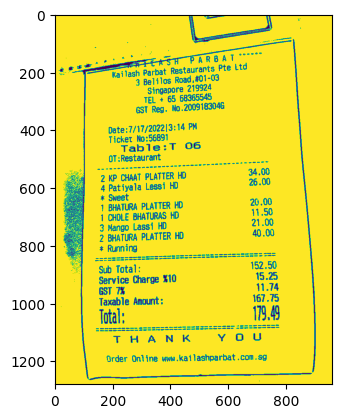

In [41]:
from img_preprocess import *

out_img = preprocess_img(cv2.imread('./test_imgs/photo_2023-01-15_02-30-33.jpg'))
# plt.imshow(out_img)
ocr_text = pytesseract.image_to_string(out_img)
print(ocr_text)

In [45]:
response = "answer = {'items':[['KP Chaat Platter HD', 34.00], ['Patiyala Lessi 4D', 26.00], ['Sweet', 0.00], ['Bhatura Platter HD', 26.00], ['Chole Bhaturas HD', 11.50], ['Mango Lassi HD', 21.00], ['Bhatura Platter HD', 40.00], ['Running', 0.00]], 'taxes':[['Service Charge %10', 15.25], ['GST 7%', 11.74]], 'total':['Total', 179.49]}"
import ast
maindict = ast.literal_eval(response.split('=')[1]))
print(type(maindict))
#str to dict


<class 'dict'>
